In [151]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [152]:

train_df = pd.read_csv('../Data/train.csv')
test_df = pd.read_csv('../Data/test.csv')


X_train_original = train_df.drop('Target', axis=1)
y_train_original = train_df['Target']
X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

print("Dados originais - Train shape:", X_train_original.shape)
print("Distribuição original:", pd.Series(y_train_original).value_counts().to_dict())


Dados originais - Train shape: (5301, 40)
Distribuição original: {2: 1767, 0: 1767, 1: 1767}


In [153]:
def simple_feature_engineering(X_train, X_test):
    print("=== APLICANDO FEATURE ENGINEERING ===")
    
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()
    
    numeric_cols = X_train.select_dtypes(include=['number']).columns[:5]
    print(f"Usando top 5 colunas numéricas: {list(numeric_cols)}")
    

    X_train_new['sum_top5'] = X_train[numeric_cols].sum(axis=1)
    X_test_new['sum_top5'] = X_test[numeric_cols].sum(axis=1)
    
    X_train_new['mean_top5'] = X_train[numeric_cols].mean(axis=1)
    X_test_new['mean_top5'] = X_test[numeric_cols].mean(axis=1)
    
    print(f"Features originais: {X_train.shape[1]}")
    print(f"Features após engineering: {X_train_new.shape[1]}")
    print("=== FEATURE ENGINEERING CONCLUÍDO ===")
    
    return X_train_new, X_test_new

# Aplicar feature engineering
X_train, X_test = simple_feature_engineering(X_train, X_test)

=== APLICANDO FEATURE ENGINEERING ===
Usando top 5 colunas numéricas: ['Application mode', 'Application order', 'Course', 'Previous qualification', 'Previous qualification (grade)']
Features originais: 42
Features após engineering: 42
=== FEATURE ENGINEERING CONCLUÍDO ===


In [154]:
print("Tipos de dados:")
print(X_train.dtypes.value_counts())

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
bool_cols = X_train.select_dtypes(include=["bool"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numéricas:", len(num_cols))
print("Booleanas:", len(bool_cols))
print("Categóricas:", len(cat_cols))

if bool_cols:
    X_train[bool_cols] = X_train[bool_cols].astype(int)
    X_test[bool_cols] = X_test[bool_cols].astype(int)
    num_cols.extend(bool_cols)
    print("Colunas booleanas convertidas para int")

Tipos de dados:
int64      21
float64    21
Name: count, dtype: int64
Numéricas: 42
Booleanas: 0
Categóricas: 0


In [155]:
num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median"))
])

cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    remainder="drop"
)

In [156]:
tree = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", tree)
])

In [157]:
param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [5, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": [None, "sqrt", "log2"],
    "clf__ccp_alpha": [0.0, 1e-5, 1e-4, 5e-4, 1e-3],
    'clf__class_weight': [None, 'balanced'],
}

In [158]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=1,
    verbose=1,
    refit=True
)

gs.fit(X_train, y_train)

print("Melhores parâmetros:", gs.best_params_)
print("Score médio CV (métrica escolhida):", gs.best_score_)

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits
Melhores parâmetros: {'clf__ccp_alpha': 0.0005, 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Score médio CV (métrica escolhida): 0.7493179967983479


In [159]:
y_pred = gs.predict(X_test)

print("\nRelatório de classificação (teste):")
print(classification_report(y_test, y_pred, digits=4))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))


Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     0.6915    0.6866    0.6890       284
           1     0.3817    0.4465    0.4116       159
           2     0.8129    0.7670    0.7893       442

    accuracy                         0.6836       885
   macro avg     0.6287    0.6334    0.6300       885
weighted avg     0.6965    0.6836    0.6893       885


Matriz de confusão:
[[195  52  37]
 [ 47  71  41]
 [ 40  63 339]]


In [160]:

best_pipe  = gs.best_estimator_
best_tree  = best_pipe.named_steps["clf"]

feat_names = []
feat_names += num_cols

if cat_cols:
    ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
    ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    feat_names = num_cols + ohe_names
else:
    feat_names = num_cols

importances = best_tree.feature_importances_
order = np.argsort(importances)[::-1]

top_k = 20 if len(importances) >= 20 else len(importances)
print(f"\nTop {top_k} features por importância:")
for i in order[:top_k]:
    print(f"{feat_names[i]}: {importances[i]:.4f}")



Top 20 features por importância:
Curricular units 2nd sem (approved): 0.4129
Tuition fees up to date_1: 0.0454
Curricular units 2nd sem (grade): 0.0408
Curricular units 1st sem (enrolled): 0.0377
Curricular units 2nd sem (enrolled): 0.0318
Age at enrollment: 0.0314
Curricular units 1st sem (approved): 0.0297
Course: 0.0290
Previous qualification (grade): 0.0273
Curricular units 1st sem (evaluations): 0.0268
Admission grade: 0.0249
Curricular units 1st sem (grade): 0.0245
Unemployment rate: 0.0238
Curricular units 2nd sem (evaluations): 0.0211
GDP: 0.0204
Father's occupation: 0.0199
Inflation rate: 0.0194
sum_top5: 0.0163
Mother's qualification: 0.0147
Mother's occupation: 0.0141


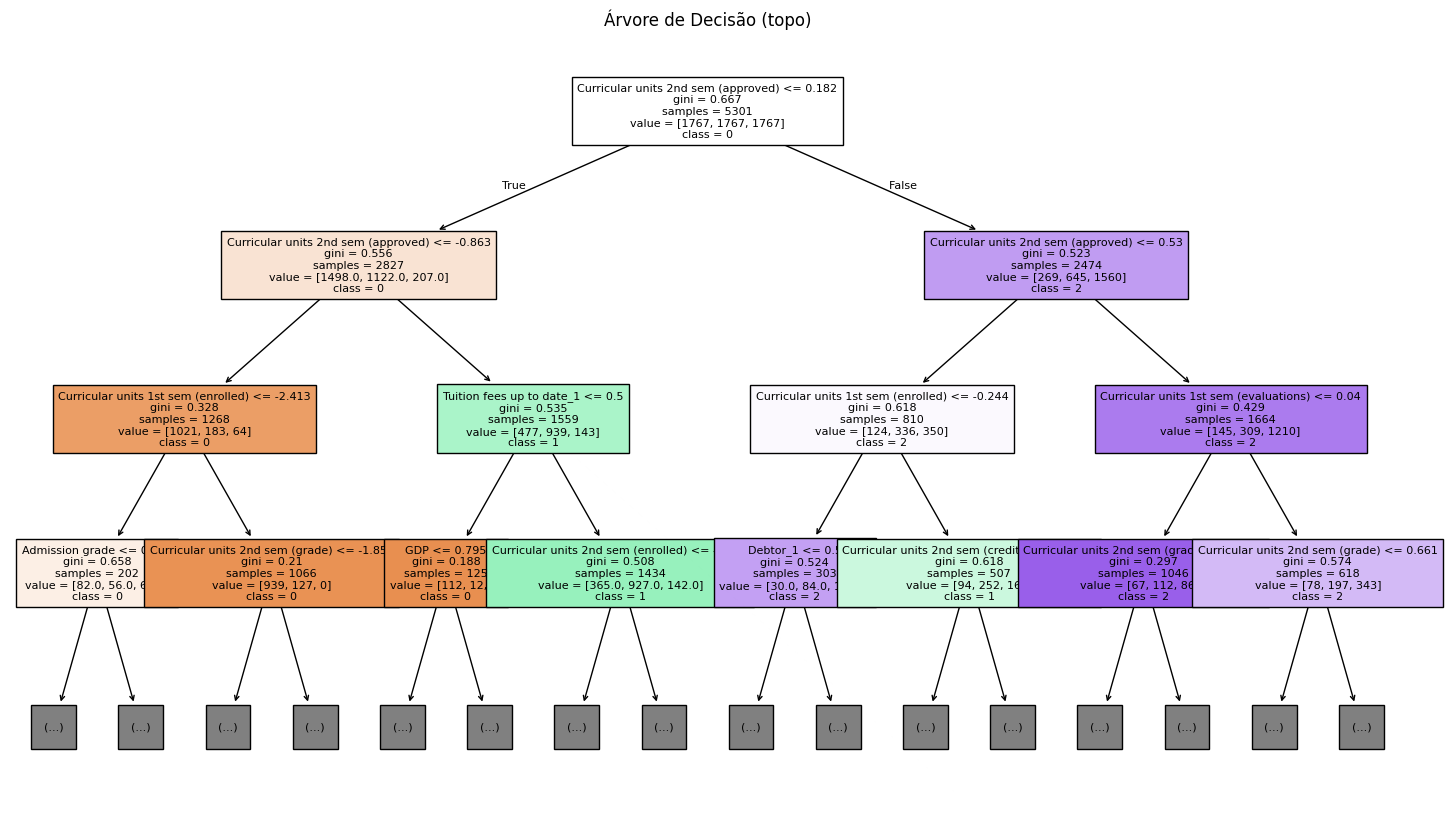

In [161]:
plt.figure(figsize=(18, 10))
plot_tree(
    best_tree,
    filled=True,
    class_names=[str(c) for c in np.unique(y_train)],
    feature_names=feat_names,
    max_depth=3,
    fontsize=8
)
plt.title("Árvore de Decisão (topo)")
plt.show()